# Librerías

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")

# Dataset

Se hace uso de la base de datos [CO2 Emissions](https://www.kaggle.com/datasets/bhuviranga/co2-emissions) obtenida de la plataforma Kaggle. La variable *X* hace referencia a las emisiones de CO2 de un modelo de carro y la variable *y* sobre el rendimiento de este en ciudad.

In [63]:
df = pd.DataFrame(pd.read_csv('CO2 Emissions.csv'))[['Fuel Consumption City (L/100 km)','CO2 Emissions(g/km)']]
X = df[['CO2 Emissions(g/km)']]
y = df[['Fuel Consumption City (L/100 km)']]

En total se tienen 7,385 registros, con los siguientes estadísticos:

In [207]:
df.describe()

,Fuel Consumption City (L/100 km),CO2 Emissions(g/km)
count,7385.000000,7385.000000
mean,12.556534,250.584699
std,3.500274,58.512679
min,4.200000,96.000000
25%,10.100000,208.000000
50%,12.100000,246.000000
75%,14.600000,288.000000
max,30.600000,522.000000


Para realizar la evaluación del modelo se separan los datos, 80% de los datos en entrenamiento y validación y 20% en prueba.
Del 80% dividido en entrenamiento y validación, de primera instancia se hará una separación de 75% y 25% respectivamente

In [64]:
X_sub1, X_test, y_sub1, y_test = train_test_split(X.values, y.values, test_size = 0.2)

In [65]:
X_train, X_val, y_train, y_val = train_test_split(X_sub1, y_sub1, test_size = 0.25)

Tamaño de cada subset

In [66]:
print('Entrenamiento:', len(X_train))
print('Validación:', len(X_val))
print('Prueba:', len(X_test))

Entrenamiento: 4431
Validación: 1477
Prueba: 1477


# Modelo

## Entrenamiento

In [67]:
modelo = LinearRegression()
modelo.fit(X = X_train, y = y_train) # entrenamiento con el set de datos correspondientes

LinearRegression()

## Modelo

Como no es regresión multivariada, se tiene la siguiente ecuación que describe al modelo:
$$ y = 0.055x -1.2878$$

In [68]:
print("Intercept:", modelo.intercept_)
print("Coeficiente:", modelo.coef_.flatten())

Intercept: [-1.28780888]
Coeficiente: [0.05524133]


## Predicción

In [69]:
y_pred = modelo.predict(X = X_test)

## Grado de sesgo

El sesgo representa el comportamiento de nuestros datos comparado con una distribución normal. Un valor positivo indica que el modelo mide por encima del valor real y un valor negativa significa que mide por debajo de este.

Además, para un modelo con mayor exactitud se recomienda tener menores niveles de sesgo. Ya que una suposición al realizar regreión lineal es la normalidad de los datos.

Como podemos observar, nuestras predicciones tienen un coeficiente medio, lo que nos indica una ligera asimetría positiva en nuestros datos.



In [70]:
import scipy.stats as sp
sp.skew(y_pred)

array([0.4904968])

## Grado de varianza

Con el set de prueba se calculó el error cuadrático medio (RMSE) y el coeficiente de determinación (R^2).

El RMSE epresenta la cantidad de error entre la predicción y observación, y R^2 refleja la proporción de varianza total que se explica por la regresión.

En promedio se espera que las predicciones  estén alejadas 1.3 unidades del dato real.

In [71]:
rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = False
       )
print(f"Error cuadrático medio (rmse): {rmse}")

Error cuadrático medio (rmse): 1.3036300892774793


Y en cuanto al R^2, este tiene un valor alto, por lo que se dice que el modelo es fuerte para futuras predicciones.

In [72]:
print("Coeficiente de determinación R^2:", modelo.score(X_test, y_test))

Coeficiente de determinación R^2: 0.8451984053284951


## Nivel de ajuste

Para analizar si hay overfitting o underfitting se necesitan obtener las métricas para los sets de entrenamiento, validación y prueba.

In [73]:
# Predicciones para distintos sets
y_pred_train = modelo.predict(X = X_train)
y_pred_val = modelo.predict(X = X_val)

In [74]:
# Error cuadrático medio para distintos sets
rmse_train = mean_squared_error(
        y_true  = y_train,
        y_pred  = y_pred_train,
        squared = False
       )

rmse_val = mean_squared_error(
        y_true  = y_val,
        y_pred  = y_pred_val,
        squared = False
       )

Como podemos observar, en los 3 sets se comporta de manera similar en cuanto a las evaluaciones y no hay diferencias significativas en estos, por lo que podemos decir que no se presenta overfitting o underfitting.

In [86]:
# Resultados
resultados = pd.DataFrame({'R^2':[modelo.score(X_train, y_train), modelo.score(X_val, y_val), modelo.score(X_test, y_test)],
'RMSE':[rmse_train, rmse_val, rmse]}, index = ['Train','Val','Test'])
resultados

,R^2,RMSE
Train,0.853015,1.364186
Val,0.822555,1.473968
Test,0.845198,1.303630


# Técnicas de regularización

Uno de los supuestos de la regresión lineal es la normalidad de los datos, debido al buen rendimiento en general del modelo, se analizará si al aplicar esta transformación nuestro nuevo modelo hace mejores predicciones.

Además, se crearán modelos con distintos porcentajes de separación para el set de entrenamiento y validación.

## Normalización de los datos

Debido a que nuestros datos tienen sesgo positivo, se realizará una transformación para su normalización con el método Yeo-Johnson con el objetivo de observar si las métricas de nuestro modelo mejoran.

### Transformación

In [76]:
from sklearn.preprocessing import PowerTransformer
# Modelo
power = PowerTransformer(method = 'yeo-johnson', standardize = True)
# Transformación X de cada set
X_train_n = power.fit_transform(X_train)
X_val_n = power.fit_transform(X_val)
X_test_n = power.fit_transform(X_test)

### Modelo

Entrenamiento

In [79]:
# Nuevo modelo
modelo_n = LinearRegression()
modelo_n.fit(X = X_train_n, y = y_train) # entrenamiento con el set de datos correspondientes

LinearRegression()

Predicciones

In [82]:
# Predicciones para distintos sets
y_pred_train_n = modelo_n.predict(X = X_train_n)
y_pred_val_n = modelo_n.predict(X = X_val_n)
y_pred_n = modelo_n.predict(X = X_test_n)

### Evaluación modelo

**Grado de sesgo.** Observamos que nuestros datos ya no tienen sesgo significativo, por lo que nuestra transformación fue exitosa.

In [83]:
sp.skew(y_pred_n)

array([0.00147644])

**Error cuadrático medio y coeficiente de determinación.**

Observamos que nuestros valores siguen siendo considerados buenos, sin embargo, en promedio, ambas métricas disminuyeron, por lo que nuestros datos sin normalizar creaban un mejor modelo.

In [87]:
rmse_n = mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred_n,
        squared = False
       )
# Error cuadrático medio para distintos sets
rmse_train_n = mean_squared_error(
        y_true  = y_train,
        y_pred  = y_pred_train_n,
        squared = False
       )

rmse_val_n = mean_squared_error(
        y_true  = y_val,
        y_pred  = y_pred_val_n,
        squared = False
       )

# Resultados
resultados_n = pd.DataFrame({'R^2':[modelo_n.score(X_train_n, y_train), modelo_n.score(X_val_n, y_val), modelo_n.score(X_test_n, y_test)],
'RMSE':[rmse_train_n, rmse_val_n, rmse_n]}, index = ['Train','Val','Test'])
resultados_n

,R^2,RMSE
Train,0.841258,1.417697
Val,0.812822,1.513855
Test,0.836361,1.340325


## Cambio en % de separación

En esta sección se entrenarán diversos modelos con distinto porcentaje de separación entre el training y validation set. Se graficarán sus errores y coeficientes de determinación para obtener el mejor valor del %.

In [159]:
X_sub1, X_test, y_sub1, y_test = train_test_split(X.values, y.values, test_size = 0.2)

split = np.arange(0.1, 0.91, 0.05)
RMSE, r2= list(), list()
for i in split:
  X_train, X_val, y_train, y_val = train_test_split(X_sub1, y_sub1, test_size = i)
  # Modelo
  modelo = LinearRegression()
  modelo.fit(X = X_train, y = y_train)

  # Predicciones
  # Predicciones para distintos sets
  y_pred_train = modelo.predict(X = X_train)
  y_pred_val = modelo.predict(X = X_val)

  # RMSE
  rmse_train = mean_squared_error(
          y_true  = y_train,
          y_pred  = y_pred_train,
          squared = False
        )

  rmse_val = mean_squared_error(
          y_true  = y_val,
          y_pred  = y_pred_val,
          squared = False
        )
  # Métricas
  RMSE.append([rmse_train, rmse_val])
  r2.append([modelo.score(X_train, y_train), modelo.score(X_val, y_val)])

RMSE = pd.DataFrame(RMSE, columns = ['Train','Val'], index = split)
r2 = pd.DataFrame(r2, columns = ['Train','Val'], index = split)

RMSE['Dif'] = RMSE.Train-RMSE.Val
r2['Dif'] = abs(r2.Train-r2.Val)

### RMSE

Ya que es un error, se desean valores más pequeños y con una diferencia no tan grande entre los sets para descartar overfitting o underfitting.

En el caso que el RMSE de validación esté muy por encima del de traininig, significa un posible underfitting, ya que el modelo predice bien con los valores de entrenamiento pero al ingresarles nuevos valores, este no es tan acertivo.

Por otro lado, si el training set está muy por encima del validation set, sinifica un posible overfitting, ya que el modelo se sobreajusta a los valores de entrenamiento pero no a nuevos valores.

En este caso, se quiere una diferencia no tan significativa entre ambos conjuntos de datos. Preferiblemente donde el set de validación esté por encima del training set.

<Axes: title={'center': 'RMSE for training and validation set'}>

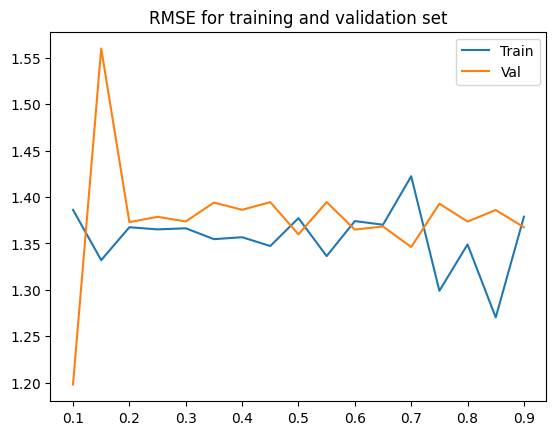

In [164]:
RMSE.drop('Dif', axis = 1).plot(title = 'RMSE for training and validation set')

En la gráfica de diferencia de errores de los sets, se aprecia que los valores positivos es donde el training set tuvo un mayor error que el de validaton. En este caso, debido a que se trata de un error, se busca un punto donde el set de validación tenga un mayor valor que el de training (diferencias negativas) y un menor error que el primer modelo de este documento.

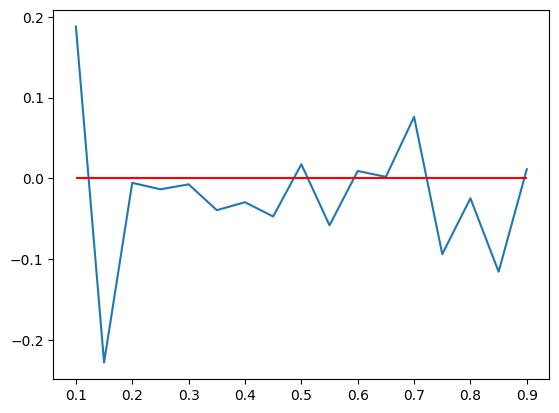

In [165]:
plt.plot(RMSE.Dif)
plt.hlines(0, xmin = split[0], xmax = split[-1], color = 'red')

In [174]:
RMSE_split = RMSE[(RMSE.Dif <= 0) & (RMSE.Train <= resultados.RMSE.Train) & (RMSE.Val <= resultados.RMSE.Val)]
RMSE_split

,Train,Val,Dif
0.35,1.354617,1.394003,-0.039387
0.40,1.356718,1.386268,-0.029549
0.45,1.347216,1.394448,-0.047232
0.55,1.336365,1.394519,-0.058154
0.75,1.299027,1.392852,-0.093825
0.80,1.348917,1.373592,-0.024675
0.85,1.270318,1.385990,-0.115672


### R^2

En este caso, a diferencia del error, se desean valores más altos, igual con una diferencia no tan grande entre los sets para descartar overfitting o underfitting.

En el caso que el training set esté muy por encima del validation set, significa un posible overfitting, donde nuestro modelo funciona muy bien con los datos conocidos pero con los nuevos no predice bien. En el caso contrario,

En este caso, se quiere una diferencia no tan significativa entre ambos conjuntos de datos. Como la ubicación del training set respecto al validation set no es de tanta importancia como en el caso de RMSE, se considera la diferencia absoluta entre sus coeficientes.

<Axes: title={'center': 'RMSE for training and validation set'}>

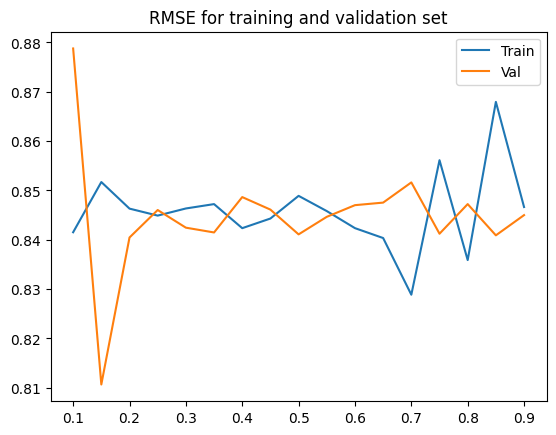

In [167]:
r2.drop('Dif', axis = 1).plot(title = 'RMSE for training and validation set')

Observamos que la diferencia entre nuestros sets disminuye drásticamente entre en los primeros porcentajes, y no se observa alguna tendencia.

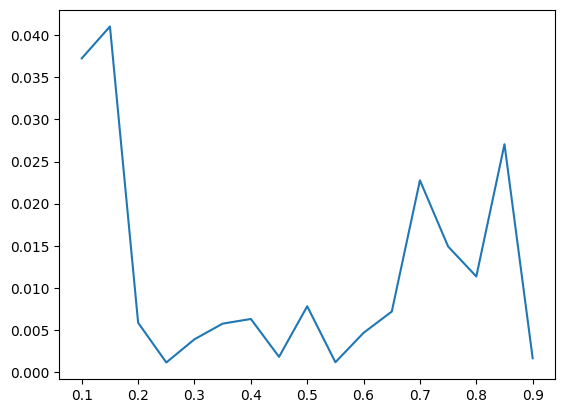

In [169]:
plt.plot(r2.Dif)

Se desea encontrar un % de separación que obtenga coeficientes mayores que en el primer modelo de nuestro proyecto y con una diferencia no significativa:

In [173]:
R2_split = r2[(r2.Train >= resultados['R^2'].Train) & (r2.Val >= resultados['R^2'].Val)]
R2_split

,Train,Val,Dif
0.75,0.856123,0.841217,0.014906
0.85,0.867947,0.840888,0.027060


### Selección

De nuestro análisis de ambas métricas obtenemos que los siguientes % de separación mejoran el R^2 o el RMSE, según sea el caso. Y los valores que aparecen en ambas mejoras son los: 75% y 85%. Los cuales tienen las siguientes métricas:

In [182]:
# Error cuadrático medio
RMSE_split.iloc[[4,6]]

,Train,Val,Dif
0.75,1.299027,1.392852,-0.093825
0.85,1.270318,1.385990,-0.115672


In [175]:
# Coeficiente de determinación
R2_split

,Train,Val,Dif
0.75,0.856123,0.841217,0.014906
0.85,0.867947,0.840888,0.027060


Sus valores son muy similares, por lo que se decide escoger una separación del 75%, debido a que en ambas métricas tiene menores diferencias. Esto significaría una distribución del 25% para el set de entrenamiento y 75% para el de validación.

### Modelo final

25% para datos de entrenamiento y 75% en validación.

In [191]:
X_train, X_val, y_train, y_val = train_test_split(X_sub1, y_sub1, test_size = 0.75)

# Modelo
modelo = LinearRegression()
modelo.fit(X = X_train, y = y_train)

# Predicciones
y_pred_val = modelo.predict(X = X_val)
y_pred = modelo.predict(X = X_test)

In [186]:
# RMSE
rmse_test = mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = False
      )

rmse_val = mean_squared_error(
        y_true  = y_val,
        y_pred  = y_pred_val,
        squared = False
        )

Error cuadrático medio
Validation: 1.37
Test: 4.8
--------------------------------
Coeficiente determinación
Validation: 0.84
Test: 0.85


Observamos que para el set de prueba el RMSE se eleva mucho.

In [ ]:
print('Error cuadrático medio')
print('Validation:', round(rmse_val,2))
print('Test:', round(rmse_test,2))
print('--------------------------------')
print('Coeficiente determinación')
print('Validation:', round(modelo.score(X_val, y_val),2))
print('Test:', round(modelo.score(X_test, y_test),2))

**Gráficas**


En las siguientes gráficas podemos observar el ajuste de nuestra recta con los datos, donde el color claro representan las observaciones y los más oscuros las predicciones.

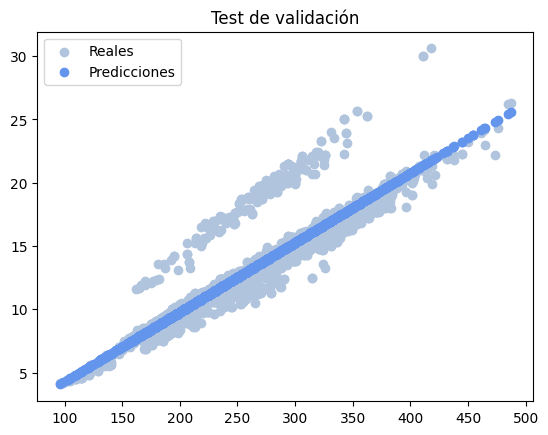

In [206]:
plt.scatter(X_val,y_val, color = 'lightsteelblue')
plt.scatter(X_val,y_pred_val, color = 'cornflowerblue')
plt.title('Test de validación')
plt.legend(['Reales','Predicciones'])

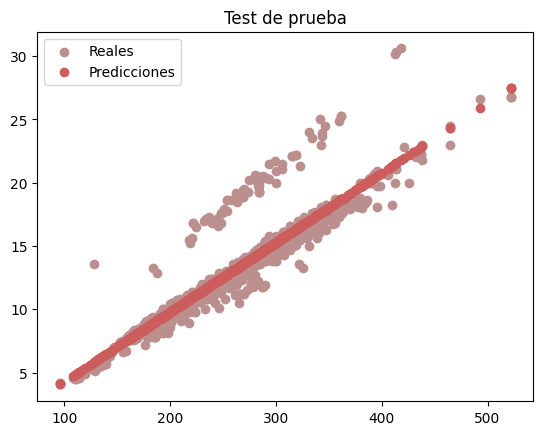

In [205]:
plt.scatter(X_test,y_test, color = 'rosybrown')
plt.scatter(X_test,y_pred, color = 'indianred')
plt.title('Test de prueba')
plt.legend(['Reales','Predicciones'])